In [1]:
import skimage
import skimage.io as io
from skimage.color import rgb2gray
import numpy as np
from collections import defaultdict
import math
import matplotlib.pyplot as plt
import csv
from skimage.filters import threshold_otsu
import copy
import os
import pylab as pl
from matplotlib import collections  as mc

# Thresholding

In [2]:
from skimage.filters import threshold_otsu, threshold_adaptive, threshold_local, threshold_minimum, threshold_mean, threshold_triangle, try_all_threshold
from skimage.util import invert

In [3]:
# os.chdir("/home/user/Desktop")

In [4]:
# section = io.imread("small/1_11.jpg")   
# section = io.imread("large/3_17.jpg") 
# section = io.imread("large/1_13.jpg")
section = io.imread("large/2_2.jpg")  
# section = io.imread("large/2_7.jpg")  
# section = io.imread("large/3_5.jpg") 

# section[51:70, 30:60] = section[1:20, 2:32]
# io.imshow(section)

gray_section = rgb2gray(section) 

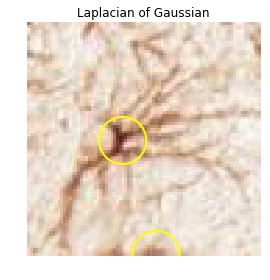

In [5]:
from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh

image_gray = gray_section
image_gray = invert(image_gray)

blobs_log = blob_log(image_gray, min_sigma=6, max_sigma=20, num_sigma=10, threshold=0.1, overlap=0.3)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('Laplacian of Gaussian')
ax.imshow(section, interpolation='nearest')

for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='yellow', linewidth=2, fill=False)
    ax.add_patch(c)
    
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [6]:
# find the blobs too close to border so as to eliminate them

def eliminate_border_blobs(blobs_log):
    blobs_dict = defaultdict()
    for i, blob in enumerate(blobs_log):
        blobs_dict[i] = blob
        y, x, r = blob
        image_border_x, image_border_y = image_gray.shape[0]/4, image_gray.shape[1]/4
        if x < image_border_x or x > 3*image_border_x or y < image_border_y or y > 3*image_border_y:
            blobs_dict.pop(i)
            
    return blobs_dict

In [7]:
# find the blob with highest intensity value

def centre_of_mass(blobs_dict):
    ixs = np.indices(image_gray.shape)
    xms = []
    yms = []
    ms = []
    for i, blob in blobs_dict.items():
        y, x, r = blob
        # Define an array of shape `[2, 1, 1]`, containing the center of the blob
        blob_center = np.array([y, x])[:, np.newaxis, np.newaxis]
        # Using the formula for a circle, `x**2 + y**2 < r**2`, generate a mask for this blob.
        mask = ((ixs - blob_center)**2).sum(axis=0) < r**2
        # Calculate the average intensity of pixels under the mask
        blob_avg_est = image_gray[mask].mean()
        yms.append(blob_avg_est*y)
        xms.append(blob_avg_est*x)
        ms.append(blob_avg_est)
        # print(f'Blob {i}: Centre {(x, y)}, average value: {blob_avg_est:.2f}')
    return (sum(yms)/sum(ms), sum(xms)/sum(ms))

In [8]:
remaining_blobs = eliminate_border_blobs(blobs_log)

if len(remaining_blobs)==1:
    soma = list(remaining_blobs.values())[0][:2]
if len(remaining_blobs)>1:
    soma = centre_of_mass(remaining_blobs)
    
soma

array([42., 34.])

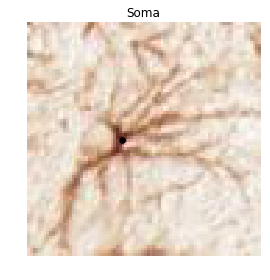

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('Soma')
ax.imshow(section, interpolation='nearest')

y, x = soma[0], soma[1]
c = plt.Circle((x, y), 1, color='black')
ax.add_patch(c)
    
ax.set_axis_off()
plt.tight_layout()
plt.show()

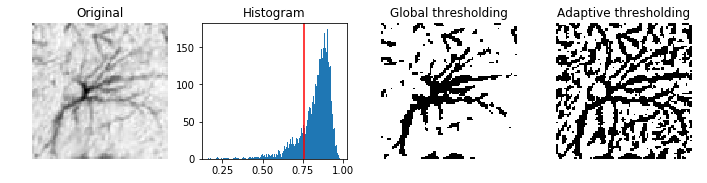

In [10]:
binary_global = gray_section > threshold_otsu(gray_section)

block_size = 21
binary_adaptive = gray_section > threshold_local(gray_section, block_size, offset=0)

fig, axes = plt.subplots(ncols=4, figsize=(12, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 4, 1)
ax[1] = plt.subplot(1, 4, 2)
ax[2] = plt.subplot(1, 4, 3, sharex=ax[0], sharey=ax[0])
ax[3] = plt.subplot(1, 4, 4, sharex=ax[0], sharey=ax[0])

ax[0].imshow(gray_section, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(gray_section.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(threshold_otsu(gray_section), color='r')

ax[2].imshow(binary_global, cmap=plt.cm.gray)
ax[2].set_title('Global thresholding')
ax[2].axis('off')

ax[3].imshow(binary_adaptive, cmap=plt.cm.gray)
ax[3].set_title('Adaptive thresholding')
ax[3].axis('off')

plt.show()

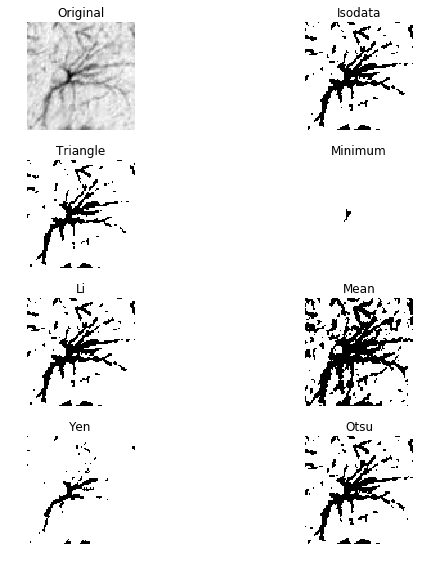

In [11]:
fig, ax = try_all_threshold(gray_section, figsize=(10, 8), verbose=False)
plt.show()

# Skeletonization

In [12]:
from skimage.morphology import skeletonize, skeletonize_3d

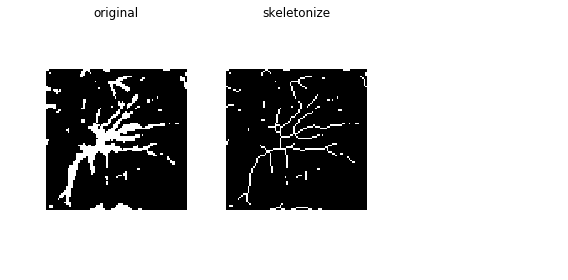

In [13]:
# Invert the astrocyte image
binary_global = gray_section > threshold_triangle(gray_section)
data = invert(binary_global)

# perform skeletonization
skeleton = skeletonize(data)
# skeleton3d = skeletonize_3d(data)

# display results
fig, axes = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(data, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(skeleton, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('skeletonize')
ax[1].axis('off')

# ax[2].imshow(skeleton3d, cmap=plt.cm.gray, interpolation='nearest')
# ax[2].set_title('skeletonize_3d')
ax[2].axis('off')

fig.tight_layout()
plt.show()

In [14]:
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import matplotlib.patches as mpatches

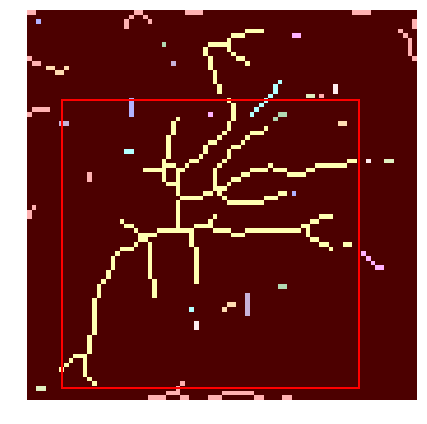

In [15]:
bw = closing(skeleton, square(1))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=skeleton)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

no_of_regions = 0
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 50:
        no_of_regions+=1
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
#         ax.imshow(label_image[minr:maxr, minc:maxc])

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [16]:
# if no_of_regions>1:
#     increase the region area size iteratively till only one region is detected

In [17]:
from skimage import morphology

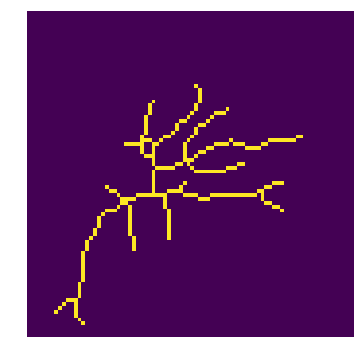

In [18]:
boxed_astrocyte = label_image
final = morphology.remove_small_objects(boxed_astrocyte, 50)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(final)
ax.set_axis_off()
plt.show()

In [19]:
def distance(P1, P2):
# Computing the distance between 2 points
    return ((P1[0] - P2[0])**2 + (P1[1] - P2[1])**2) ** 0.5

In [20]:
cell_pixel_coordinates = [(i, j) for (i, j), val in np.ndenumerate(final) if val!=0]

In [21]:
# import networkx as nx

# # Create Directed Graph
# G=nx.Graph()

# # Add a list of nodes:
# nodes_dict = defaultdict()
# for i, j in enumerate(cell_pixel_coordinates):
#     nodes_dict[j] = i
#     G.add_node(i)

# for_edges = copy.deepcopy(cell_pixel_coordinates)
# while for_edges:
#     start = for_edges[0]
#     for v in for_edges:
#         if distance(v, start) < 2 and distance(v, start) != 0:
#             G.add_edge(nodes_dict[v], nodes_dict[start])
#     for_edges.remove(start)

# # Add a list of edges

# # def eliminate_loops():

In [22]:
# graph = list(G.edges())
# cycles = []

# def main():
#     global graph
#     global cycles
#     for edge in graph:
#         for node in edge:
#             findNewCycles([node])
#     for cy in cycles:
#         path = [str(node) for node in cy]
#         s = ",".join(path)
#         print(s)

# def findNewCycles(path):
#     start_node = path[0]
#     next_node= None
#     sub = []

#     #visit each edge and each node of each edge
#     for edge in graph:
#         node1, node2 = edge
#         if start_node in edge:
#                 if node1 == start_node:
#                     next_node = node2
#                 else:
#                     next_node = node1
#         if not visited(next_node, path):
#                 # neighbor node not on path yet
#                 sub = [next_node]
#                 sub.extend(path)
#                 # explore extended path
#                 findNewCycles(sub);
#         elif len(path) > 2  and next_node == path[-1]:
#                 # cycle found
#                 p = rotate_to_smallest(path);
#                 inv = invert(p)
#                 if isNew(p) and isNew(inv):
#                     cycles.append(p)

# def invert(path):
#     return rotate_to_smallest(path[::-1])

# #  rotate cycle path such that it begins with the smallest node
# def rotate_to_smallest(path):
#     n = path.index(min(path))
#     return path[n:]+path[:n]

# def isNew(path):
#     return not path in cycles

# def visited(node, path):
#     return node in path

# main()

In [23]:
# G.edges.data()
# list(G.edges())

In [24]:
soma_on_skeleton = min(cell_pixel_coordinates, key=lambda x: distance(soma, x))

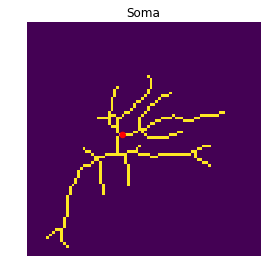

In [25]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('Soma')
ax.imshow(final, interpolation='nearest')

y, x = soma_on_skeleton
c = plt.Circle((x, y), 1, color='red')
ax.add_patch(c)
    
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [26]:
soma_on_skeleton

(40, 34)

In [27]:
def labelling(coords):
    labels = defaultdict()
    for coord in coords:
        indices = [v for i, v in enumerate(coords) if distance(v, coord) < 2 and distance(v, coord) != 0]
        if len(indices)==2:
            labels[coord]="slab"
        if len(indices)<2:
            labels[coord]="termination"
        if len(indices)>2:
            labels[coord]="junction"
    return labels

In [28]:
# def prune_junctions(labels):
#     junctions = [key for key, value in labels.items() if value=="junction"]
#     for i in indices:
#         neighbouring_junctions = [v for coord in junctions if distance(i, coord) < 2 and distance(i, coord) != 0]
#         for j in neighbouring_junctions:
            

In [29]:
# def optimized_path(coords, start):
#     """
#     This function finds the nearest point to a point
#     coords should be a list in this format coords = [ [x1, y1], [x2, y2] , ...] 
#     """
#     forks=[]
#     pass_by = copy.deepcopy(coords)
#     path = [start]
#     pass_by.remove(start)
#     while pass_by:
#         nearest = min(pass_by, key=lambda x: distance(path[-1], x))
#         indices = [v for i, v in enumerate(pass_by) if distance(v, path[-1]) < 2]
# #         termination_indices = [v for i, v in enumerate(pass_by) if distance(v, path[-1]) > 2]
#         if len(indices) > 1:
#             print(path[-1], "-->", indices)
#             forks.append(path[-1])
#         path.append(nearest)
#         pass_by.remove(nearest)
#     return forks[1:]

In [30]:
# def nearests(coords, point):
#     indices = [v for i, v in enumerate(coords) if distance(v, point) < 2]
    
#     return indices
    
# def get_nested(graph):
#     if isinstance(graph, list):
#         for i in graph:
# #             if isinstance(i, list):
# #                 for j in i:
#                     for k in get_nested(i):
#                         if isinstance(k, tuple):
#                             i.append(k)
                
#                         next_point = nearest(k)
#     else:
#         next_point = nearest(graph)
        
#     return next_point

In [31]:
# # define a start point
# start = soma_on_skeleton
# forks = optimized_path(cell_pixel_coordinates, start)

In [32]:
labels = labelling(cell_pixel_coordinates)

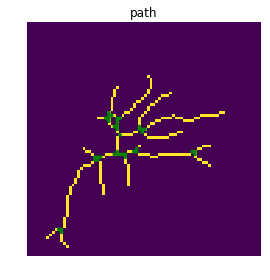

In [33]:
import pylab as pl
from matplotlib import collections  as mc

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('path')
ax.imshow(final, interpolation='nearest')

forks = [key for key, value in labels.items() if value=="junction"]

for i in forks:
    c = plt.Circle((i[1], i[0]), 0.5, color='green')
    ax.add_patch(c)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [34]:
terminations = [key for key, value in labels.items() if value=="termination"]

def pruning(terminations, cell_pixel_coordinates, labels):
    sorted_branch_orders = []
    for coord in terminations:
        branches = []
        pass_by = copy.deepcopy(cell_pixel_coordinates)
        nearest = coord
        pass_by.remove(nearest)
        while labels[nearest]!="junction":
            branches.append((nearest, labels[nearest]))
            nearest = min(pass_by, key=lambda x: distance(nearest, x))
            pass_by.remove(nearest)
        branches.append((nearest, labels[nearest]))
        sorted_branch_orders.append(branches)
    return sorted_branch_orders
    
sorted_branch_orders = pruning(terminations, cell_pixel_coordinates, labels)
# sorted_branch_orders

In [35]:
cell_pixel_coordinates_1 = copy.deepcopy(cell_pixel_coordinates)
for j in sorted_branch_orders:
    for i in j:
        try:
            cell_pixel_coordinates_1.remove(i[0])
        except ValueError:
            pass

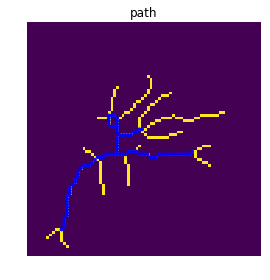

In [36]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('path')
ax.imshow(final, interpolation='nearest')

for i in cell_pixel_coordinates_1:
    c = plt.Circle((i[1], i[0]), 0.5, color='blue')
    ax.add_patch(c)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [37]:
labels_1 = labelling(cell_pixel_coordinates_1)
terminations_1 = [key for key, value in labels_1.items() if value=="termination"]
sorted_branch_orders_1 = pruning(terminations_1, cell_pixel_coordinates_1, labels_1)

In [38]:
cell_pixel_coordinates_2 = copy.deepcopy(cell_pixel_coordinates_1)
for j in sorted_branch_orders_1:
    for i in j:
        try:
            cell_pixel_coordinates_2.remove(i[0])
        except ValueError:
            pass

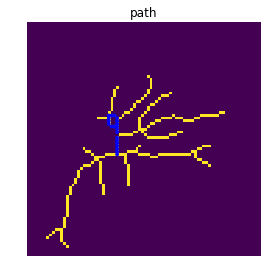

In [39]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('path')
ax.imshow(final, interpolation='nearest')
for i in cell_pixel_coordinates_2:
    c = plt.Circle((i[1], i[0]), 0.5, color='blue')
    ax.add_patch(c)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [40]:
# sorted_branch_orders_1

In [41]:
# sorted_branch_orders

If more than two objects are still there then black out the small one i.e with less pixel sum value

In [42]:
# cell_pixel_coordinates = [(i,j) for (i, j), val in np.ndenumerate(boxed_astrocyte) if val==0]

# def cell_neighbors(boxed_astrocyte, cell_pixel_coordinates, d):
#     """Return d-th neighbors of cell (i, j)"""
#     windows = []
#     for k in cell_pixel_coordinates:
#         window = boxed_astrocyte[i-d:i+d+1, j-d:j+d+1].flatten()
#     windows.append(window)
#     return windows

In [43]:
# fork_windows = []
# end_point_windows = []
# for window in cell_neighbors():
#     if window[window.shape - 1, window.shape - 1] == 0:
#     # check if centre is black then only proceed
#         no_of_black_neighbors = 0
#     for (i, j), val in np.ndenumerate(window):
#         if val==0:
#             no_of_black_neighbors+=1
#     if no_of_black_neighbors == 2:
#         end_point_windows.append(window)
#     if no_of_black_neighbors >= 3:
#         fork_windows.append(window)

In [44]:
def sholl(cell_image, soma):

    concentric_coordinates = defaultdict(list) # {100: [(10,10), ..] , 400: [(20,20), ..]}
    concentric_coordinates_intensities = defaultdict(list)
    concentric_radiuses = [4, 8, 12, 16, 20, 24, 28, 32, 36]
    # concentric_radiuses = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    
    for (x, y), value in np.ndenumerate(cell_image):
        for radius in concentric_radiuses:
            lhs = (x - soma[1])**2 + (y - soma[0])**2
            if abs((math.sqrt(lhs)-radius)) < 0.9:
                concentric_coordinates[radius].append((x, y))
                concentric_coordinates_intensities[radius].append(cell_image[x, y])

    x = []
    y = []

    for radius, intensity_values in concentric_coordinates_intensities.items(): 
        intensity = sum(intensity_values)
        # intensity = sum(intensity_values)/(2*(22/7)*radius)
        x.append(radius)
        y.append(intensity)

    return concentric_coordinates, concentric_coordinates_intensities

In [45]:
inverted_cell_image = skimage.util.invert(final)
concentric_coordinates, concentric_intensities = sholl(inverted_cell_image, soma)
for radius, coordinates in concentric_coordinates.items():
    for coord in coordinates:
        cell_image_with_circles = inverted_cell_image
        cell_image_with_circles[coord[0],coord[1]]=5
# io.imshow(cell_image_with_circles)
# io.show()

/Users/parul/.virtualenvs/gensim3/lib/python3.4/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in longlong_scalars


/Users/parul/.virtualenvs/gensim3/lib/python3.4/site-packages/skimage/util/dtype.py:47: UserWarning: The default of `clip_negative` in `skimage.util.dtype_limits` will change to `False` in version 0.15.
  warn('The default of `clip_negative` in `skimage.util.dtype_limits` '


(0, 9223372036854775807)


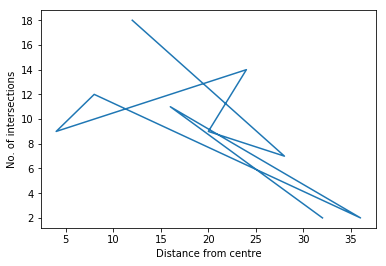

In [46]:
print(skimage.dtype_limits(final))
binary = final > threshold_otsu(final)
concentric_coordinates, concentric_intensities = sholl(binary, soma)
    
x = []
y = []
for rad, val in concentric_intensities.items():
    avg = sum(val)
    x.append(rad)
    y.append(avg)

plt.plot(x, y)
plt.xlabel("Distance from centre")
plt.ylabel("No. of intersections") 
plt.show()

In [47]:
# def plot_folder_avg():
#     avg_intensities = defaultdict(list)
#     for file in os.listdir('.'):
#         cell_image = io.imread(file)
#         gray_cell_image = rgb2gray(cell_image)
#         inverted_cell_image = skimage.util.invert(gray_cell_image)
#         concentric_coordinates, concentric_intensities = sholl(inverted_cell_image, soma)

#         for radius, value in concentric_intensities.items():
#             avg_intensities[radius].append(value)
#     x = []
#     y = []

#     for rad, val in avg_intensities.items():
#         all_intensity_vals = [i[0] for i in val]
#         avg = sum(all_intensity_vals)/ len(val)
#         x.append(rad)
#         y.append(avg)
        
#     return x, y

# os.chdir("/home/user/Desktop/small")
# x, q = plot_folder_avg()

# os.chdir("/home/user/Desktop/large")
# x, z = plot_folder_avg()

# plt.plot(x, q)
# plt.plot(x, z)
# plt.legend(['y = small', 'y = large'], loc='upper right')
# plt.xlabel("Distance from centre")
# plt.ylabel("Intensity")
# plt.show()

## Confocal

In [48]:
# os.chdir("/home/user/Desktop")

In [49]:
# confocal_section = io.imread("confocal images/SingleGreenchannel.tif")                                   
# confocal_gray_section = rgb2gray(confocal_section) 

In [50]:
# binary_global = confocal_gray_section > threshold_triangle(confocal_gray_section)
# data = invert(binary_global)

# # display results
# fig, ax = plt.subplots(figsize=(9,5))
# ax.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
# ax.set_title('original')
# ax.set_axis_off()
# fig.tight_layout()
# plt.show()

In [51]:
# bw = closing(binary_global, square(1))

# # remove artifacts connected to image border
# cleared = clear_border(bw)

# # label image regions
# label_image = label(cleared)
# image_label_overlay = label2rgb(label_image, image=data)

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.imshow(image_label_overlay)

# for region in regionprops(label_image):
#     # take regions with large enough areas
#     if region.area >= 400:
#         # draw rectangle around segmented coins
#         minr, minc, maxr, maxc = region.bbox
#         rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
#                                   fill=False, edgecolor='red', linewidth=2)
#         ax.add_patch(rect)

# ax.set_axis_off()
# plt.tight_layout()
# plt.show()

In [52]:
# from skimage import morphology

In [53]:
# boxed_astrocyte = label_image[minr:maxr, minc:maxc]
# final = morphology.remove_small_objects(boxed_astrocyte, 50)
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.imshow(final)
# ax.set_axis_off()
# plt.show()

In [54]:
# import mahotas

# # nuclear = mahotas.imread(nuclear_path)
# nuclear = mahotas.gaussian_filter(binary_global, 3.)
# threshed  = (nuclear > nuclear.mean())
# distances = mahotas.stretch(mahotas.distance(threshed))
# Bc = np.ones((9,9))

# maxima = mahotas.morph.regmax(distances, Bc=Bc)
# spots,n_spots = mahotas.label(maxima, Bc=Bc)
# surface = (distances.max() - distances)
# areas = mahotas.cwatershed(surface, spots)
# areas *= threshed



# import random
# from matplotlib import colors as c
# colors = list(map(plt.cm.jet,range(0, 256, 4)))
# random.shuffle(colors)
# colors[0] = (0.,0.,0.,1.)
# rmap = c.ListedColormap(colors)
# plt.imshow(areas, cmap=rmap)
# plt.show()